# Sold! How do home features add up to its price tag?

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

The potential for creative feature engineering provides a rich opportunity for fun and learning. This dataset lends itself to advanced regression techniques like random forests and gradient boosting with the popular XGBoost library. We encourage Kagglers to create benchmark code and tutorials on Kernels for community learning. Top kernels will be awarded swag prizes at the competition close. 

#### Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.

**https://www.kaggle.com/c/house-prices-advanced-regression-techniques**

In [1]:
import pandas as pd 
import sklearn
import seaborn as sea
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

## Load in the data

In [2]:
house_prices_train = pd.read_csv('train.csv')
house_prices_test = pd.read_csv('test.csv')
house_prices_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [3]:
house_prices_train.shape, house_prices_test.shape

((1460, 81), (1459, 80))

## Modeling

#### Split the dataframe into its original train and test with all the data transformation intact

In [4]:
train = pd.read_csv('train_engineered.csv')
test = pd.read_csv('test_engineered.csv')
output = pd.read_csv('log_SalePrice.csv', header=None)
output.rename(columns={0: "log_SalePrice"}, inplace=True)
output.head(2)
print train.shape, test.shape, output.shape

(1460, 327) (1459, 327) (1460, 1)


In [5]:
train.head(2)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,5.017280,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,5.652489,...,0,0,0,1,0,0,0,0,1,0


In [6]:
output.head(2)

,log_SalePrice
0,12.247699
1,12.109016


### Modeling

In [22]:
def modelfit(model, dtrain, features, output, validation, validation_output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    model.fit(dtrain[features], output)
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
    validation_predictions = model.predict(validation[features])

    
    #Perform cross-validation:
    from sklearn import cross_validation
    from sklearn import metrics
    if performCV:
        cv_score = cross_validation.cross_val_score(model, dtrain[features], output, cv=cv_folds)
    
    #Print model report:
    print "\nModel Report"
    print "Training R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "Training RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))    
    print "Validation R-Square: %.3f" % metrics.r2_score(validation_output, validation_predictions)
    print "Validation RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(validation_output, validation_predictions))
    print('Variance score: %.2f' % model.score(validation, validation_output))
    print('Optimal Alpha: %.4f') %model.alpha_ 
    
    if performCV:
        print"Training cv_score: "
        print(cv_score)
        print "CV Score : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    if printFeatureImportance:
        df = {'features': features.values, 'Coefficients': model.coef_[0]}
        coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
        plt.figure()
        coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
        plt.ylabel('Feature Coefs')
        plt.figure()
        coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
        plt.ylabel('Feature Coefs')

In [8]:
from sklearn import linear_model

In [9]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, output, test_size=0.2, random_state=37)

In [11]:
features = X_train.columns

### Ridge Regression

In [17]:
#alpha = np.arange(0.01,10,0.05)
#print alpha
alpha = 10**np.random.uniform(-1,1, size=100)
print alpha

[ 1.11625159  0.39922599  1.68102934  0.56833295  0.10871163  6.17535536
  9.69351156  3.73072841  4.48842571  0.14912672  0.62719006  3.08357774
  3.93486218  8.09670267  0.24699175  3.64430654  0.17349999  0.52467388
  0.96402259  0.43625493  8.28109326  0.31412142  6.05296029  0.19989588
  1.01724098  9.01423661  0.16114472  0.12060964  0.10429149  8.72222981
  5.02995899  6.3431346   1.01032901  2.28509499  6.25475841  0.1886414
  4.39481994  3.98158224  0.27458212  6.23883863  0.24116199  0.12716035
  6.61896474  1.96839769  0.26040775  1.05080439  0.88895155  0.24900549
  1.985936    0.55025681  0.67167468  2.79104902  4.05544442  1.82592855
  8.46487728  0.48978213  5.06080473  1.72874125  1.57822671  0.77531001
  0.26752558  1.45464788  2.67384478  4.63335394  1.02206015  0.30906866
  0.81875233  6.34368809  0.39657822  0.62290188  0.12834588  0.22857495
  0.12361455  0.25668006  8.2116387   0.12473145  5.17630515  0.59641132
  5.6033215   5.09650783  2.23898231  8.79845916  1.

In [18]:
ridge = linear_model.RidgeCV(alphas=alpha, fit_intercept=True)


Model Report
Training R-Square: 0.944
Training RMSE : 0.095
Validation R-Square: 0.854
Validation RMSE : 0.145
Variance score: 0.85
Optimal Alpha: 5.6033
Training cv_score: 
[ 0.80782413  0.91192675  0.91414921  0.88311923  0.93084555]
CV Score : Mean: 0.889573 | Std: 0.0436615 | Min: 0.8078241 | Max: 0.9308455


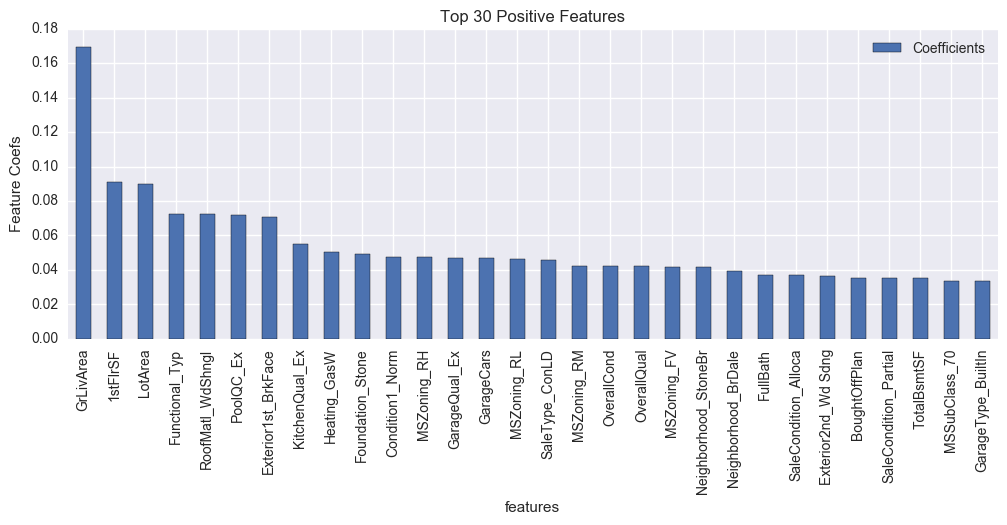

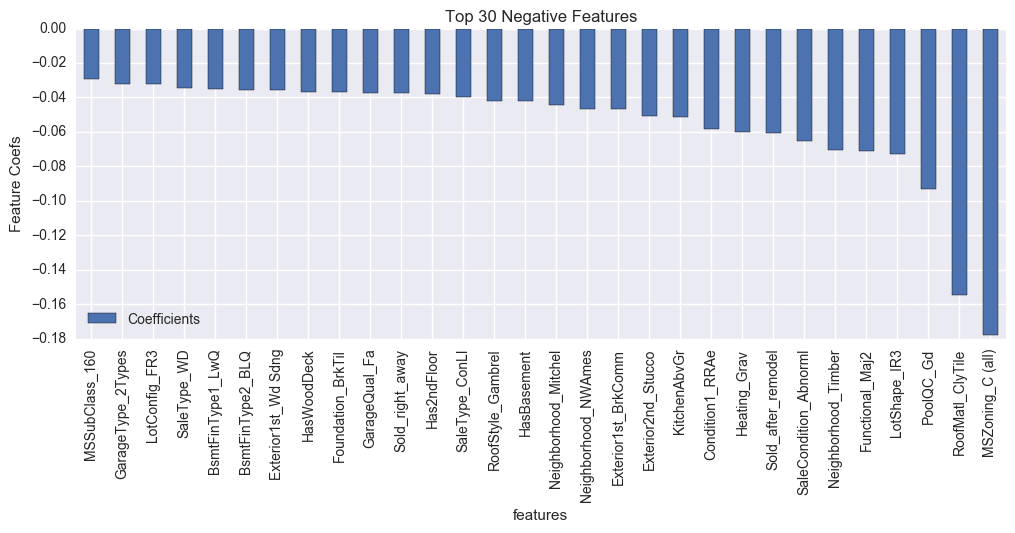

In [23]:
modelfit(ridge, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=True)

In [24]:
# The coefficients
df = {'features': X_train.columns, 'Coefficients': ridge.coef_[0]}
ridge_coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
ridge_coefficients

,Coefficients,features
14,0.169643,GrLivArea
11,0.090845,1stFlrSF
1,0.090073,LotArea
277,0.072547,Functional_Typ
174,0.072341,RoofMatl_WdShngl
305,0.071825,PoolQC_Ex
178,0.070620,Exterior1st_BrkFace
267,0.055156,KitchenQual_Ex
251,0.050475,Heating_GasW
223,0.049027,Foundation_Stone


#### Error metrics certainly look better than for Linear Regression!!!

In [25]:
ridge_prediction = np.exp(ridge.predict(test))-1
ridge_prediction[:,0]

array([ 121611.9920419 ,  158699.2052579 ,  179829.29510898, ...,
        161215.22282638,  117262.35732457,  209447.01344057])

In [26]:
df = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': ridge_prediction[:,0]})
df.head(5)

,Id,SalePrice
0,1461,121611.992042
1,1462,158699.205258
2,1463,179829.295109
3,1464,198788.473432
4,1465,202785.847870


In [27]:
#df.to_csv('kaggle_submission_ridge_12102016_1721.csv', index=False)

### Lets try Lasso

In [32]:
#alpha = np.arange(0.0001,0.0009,0.00001)
alpha = 10**np.random.uniform(-6,1,size=100)
alpha

array([  5.32807333e-06,   1.91576079e-03,   5.26272138e-06,
         1.12967461e-04,   2.27741490e-03,   1.29943753e-06,
         1.07214672e-03,   3.15921160e+00,   1.73973638e-03,
         3.21074211e-06,   1.56904108e-04,   5.15814629e-02,
         1.12352211e-04,   2.82179761e-05,   3.05459760e-02,
         6.88340342e-02,   2.85616919e-02,   6.86261983e-01,
         6.42435930e-03,   1.09644727e-04,   3.42573029e-06,
         1.98779978e-04,   6.33863281e-03,   2.38068282e-04,
         3.07424012e+00,   1.54973671e-05,   3.23563017e-05,
         2.77879381e-04,   4.81574912e-02,   7.37180872e+00,
         1.22630996e-06,   1.10261477e-01,   3.85043099e-06,
         3.30640798e-05,   1.78138853e-02,   9.74244185e-06,
         1.19158103e+00,   2.26698040e-05,   3.03093950e-02,
         1.63344274e-01,   1.77105143e-06,   6.11511748e-05,
         1.78608480e-03,   2.90600904e-02,   5.78168588e-02,
         4.08235055e-04,   3.33813328e-03,   5.06566182e-01,
         3.37236765e+00,

In [33]:
lasso = linear_model.LassoCV(fit_intercept=True, alphas=alpha)

In [34]:
modelfit(lasso, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=False)


Model Report
Training R-Square: 0.945
Training RMSE : 0.095
Validation R-Square: 0.866
Validation RMSE : 0.139
Variance score: 0.87
Optimal Alpha: 0.0004
Training cv_score: 
[ 0.80789138  0.92011112  0.92452231  0.90204141  0.93648128]
CV Score : Mean: 0.8982095 | Std: 0.04649478 | Min: 0.8078914 | Max: 0.9364813


In [35]:
# The coefficients
df = {'features': X_train.columns, 'Coefficients': lasso.coef_}
lasso_coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
lasso_coefficients

,Coefficients,features
14,2.715446e-01,GrLivArea
57,7.882832e-02,BoughtOffPlan
1,7.499104e-02,LotArea
267,6.785197e-02,KitchenQual_Ex
277,6.599744e-02,Functional_Typ
178,5.765395e-02,Exterior1st_BrkFace
133,4.988992e-02,Condition1_Norm
234,4.727246e-02,BsmtExposure_Gd
225,4.427445e-02,BsmtQual_Ex
315,4.422148e-02,SaleType_ConLD


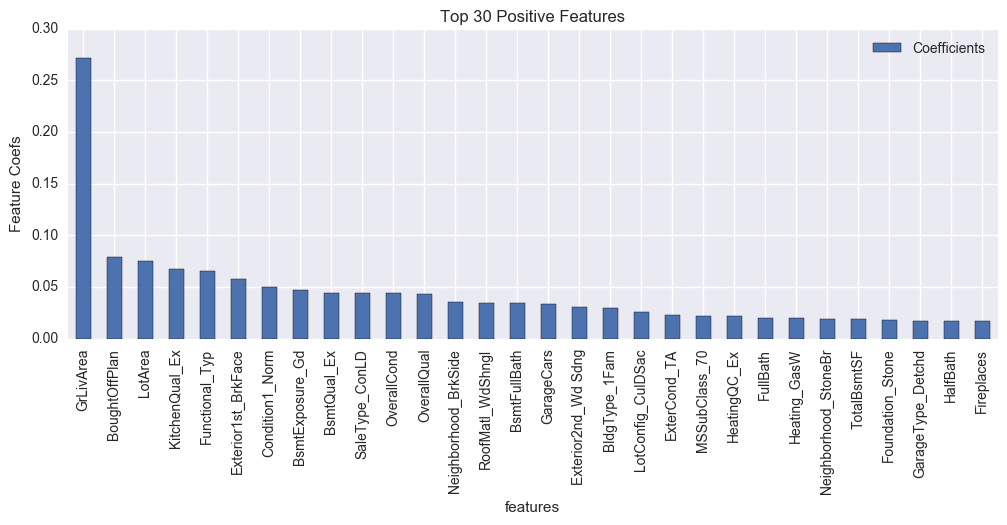

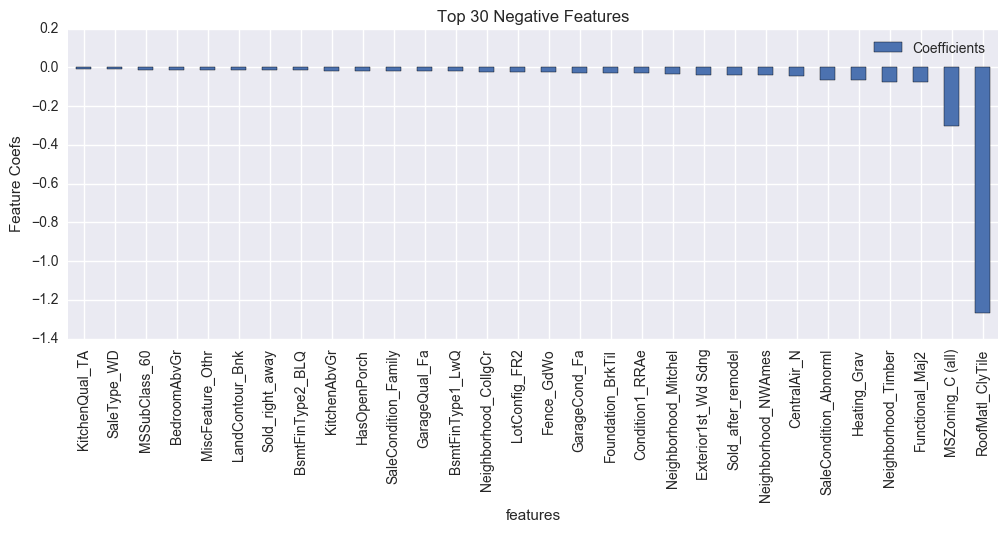

In [36]:
df = {'features': features.values, 'Coefficients': lasso.coef_}
coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
plt.figure()
coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
plt.ylabel('Feature Coefs')
plt.figure()
coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
plt.ylabel('Feature Coefs')

### Lets try another set of processed data

In [37]:
train = pd.read_csv('train_engineered2.csv')
test = pd.read_csv('test_engineered2.csv')
output = pd.read_csv('log_SalePrice2.csv', header=None)
output.rename(columns={0: "log_SalePrice"}, inplace=True)
output.head(2)
print train.shape, test.shape, output.shape

(1460, 299) (1459, 299) (1460, 1)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(train, output, test_size=0.2, random_state=37)
features = X_train.columns

In [74]:
lasso2 = linear_model.LassoCV(fit_intercept=True, alphas=alpha)

In [75]:
modelfit(lasso2, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=False)


Model Report
Training R-Square: 0.943
Training RMSE : 0.096
Validation R-Square: 0.879
Validation RMSE : 0.132
Variance score: 0.88
Optimal Alpha: 0.0004
Training cv_score: 
[ 0.84884096  0.9214531   0.92170614  0.90185449  0.93228743]
CV Score : Mean: 0.9052284 | Std: 0.02985925 | Min: 0.848841 | Max: 0.9322874


In [76]:
# The coefficients
df = {'features': X_train.columns, 'Coefficients': lasso2.coef_}
lasso_coefficients2 = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
lasso_coefficients2

,Coefficients,features
14,0.401785,GrLivArea
93,0.092485,Neighborhood_NoRidge
100,0.091033,Neighborhood_StoneBr
84,0.082715,Neighborhood_Crawfor
239,0.072785,KitchenQual_Ex
99,0.072354,Neighborhood_Somerst
249,0.069864,Functional_Typ
1,0.069747,LotArea
150,0.064832,Exterior1st_BrkFace
146,0.058301,RoofMatl_WdShngl


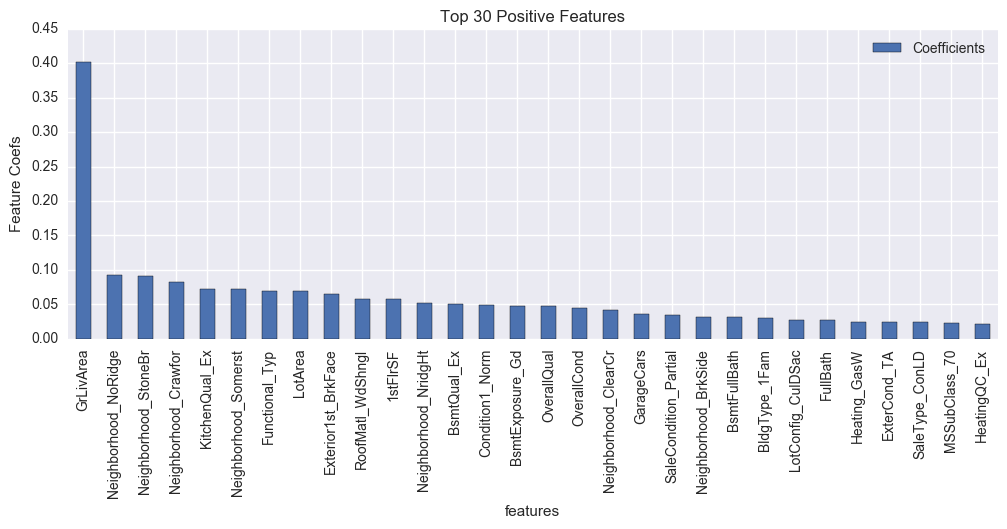

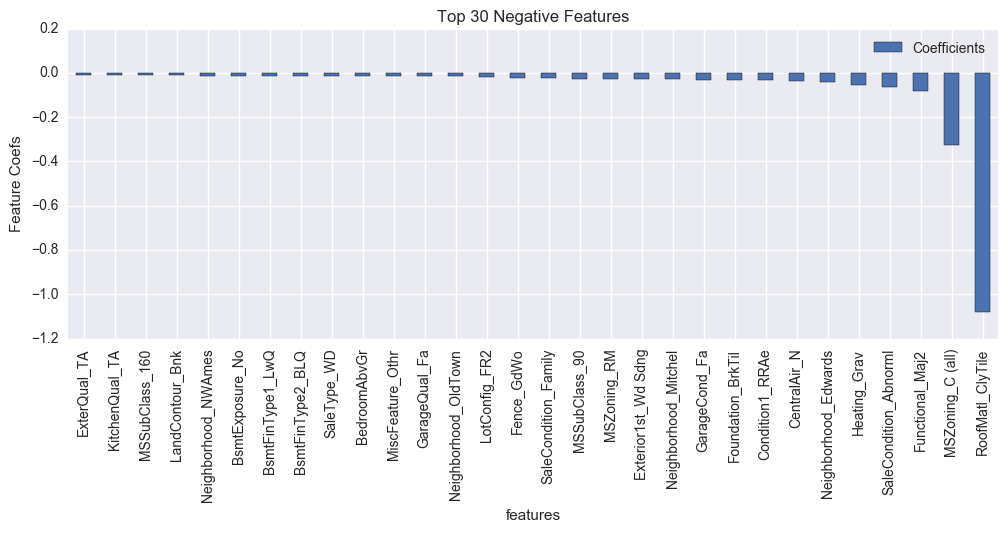

In [77]:
coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
plt.figure()
coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
plt.ylabel('Feature Coefs')
plt.figure()
coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
plt.ylabel('Feature Coefs')

### Lets submit the results to kaggle

In [67]:
prediction = np.expm1(lasso2.predict(test))
prediction

array([ 121731.81553993,  156388.62900143,  179713.18822747, ...,
        163970.80477182,  117051.73071529,  220868.78380384])

In [68]:
df = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': prediction})
df.head(5)

,Id,SalePrice
0,1461,121731.815540
1,1462,156388.629001
2,1463,179713.188227
3,1464,196505.777224
4,1465,198846.856435


In [69]:
df.to_csv('kaggle_submission_lasso_01012017.csv', index=False)

### Lets try another set of processed data

In [90]:
train = pd.read_csv('train_human_analog.csv')
test = pd.read_csv('test_human_analog.csv')
output = pd.read_csv('output_human_analog.csv', header=None)
output.rename(columns={0: "log_SalePrice"}, inplace=True)
output.drop(0, axis=0, inplace=True)
output.head(2)
print train.shape, test.shape, output.shape

(1456, 403) (1459, 403) (1456, 1)


In [91]:
output.head(5)

,log_SalePrice
1,12.2476991164
2,12.1090164423
3,12.3171711673
4,11.8494048444
5,12.4292201968


In [92]:
X_train, X_test, y_train, y_test = train_test_split(train, output, test_size=0.2, random_state=37)
features = X_train.columns

In [93]:
lasso3 = linear_model.LassoCV(fit_intercept=True, alphas=alpha)

In [94]:
modelfit(lasso3, X_train, features, y_train, X_test, y_test, performCV=True, printFeatureImportance=False)


Model Report
Training R-Square: 0.947
Training RMSE : 0.091
Validation R-Square: 0.909
Validation RMSE : 0.120
Variance score: 0.91
Optimal Alpha: 0.0005
Training cv_score: 
[ 0.90800214  0.91409229  0.91651396  0.92300424  0.92823103]
CV Score : Mean: 0.9179687 | Std: 0.007030608 | Min: 0.9080021 | Max: 0.928231


In [95]:
# The coefficients
df = {'features': X_train.columns, 'Coefficients': lasso3.coef_}
lasso_coefficients2 = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
lasso_coefficients2

,Coefficients,features
125,0.119621,_MSZoning_FV
9,0.119211,GrLivArea
126,0.088215,_MSZoning_RH
137,0.062745,_Neighborhood_BrkSide
26,0.058691,OverallQual
53,0.049681,MSZoning
189,0.045587,_Exterior1st_BrkFace
309,0.044723,_KitchenQual_Ex
161,0.040599,_Condition1_Norm
27,0.037810,OverallCond


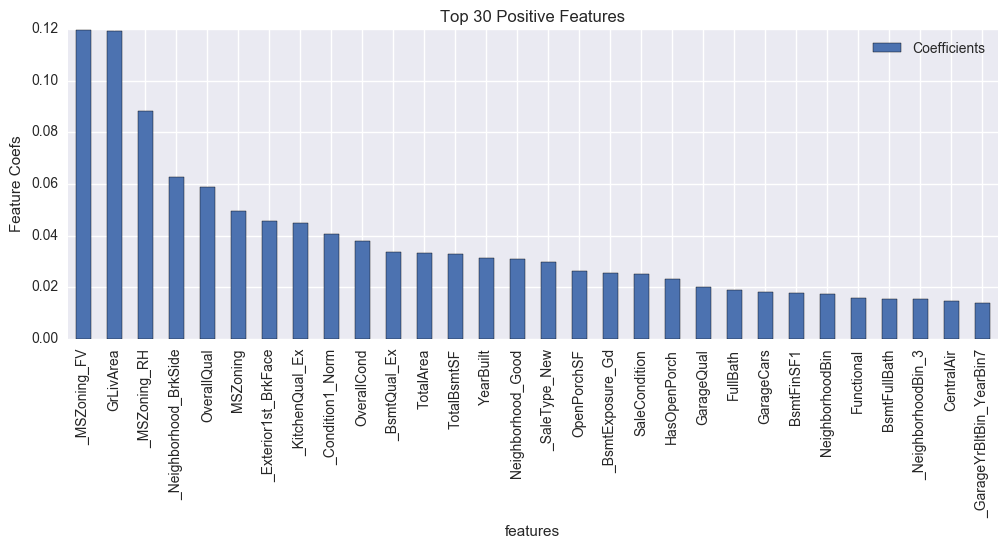

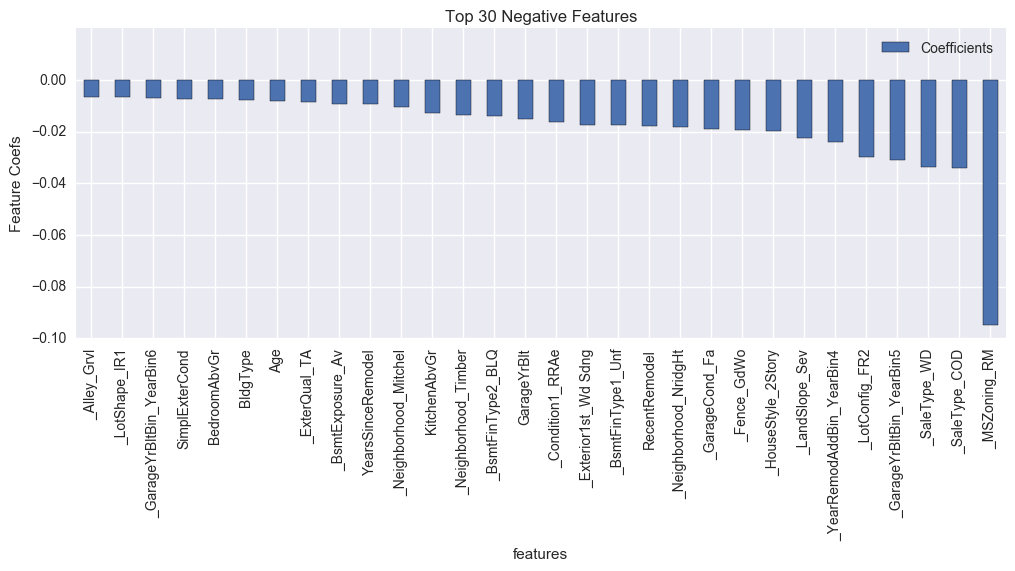

In [96]:
coefficients = pd.DataFrame(df).sort_values(by='Coefficients', ascending=False)
plt.figure()
coefficients.iloc[0:30].plot(x=['features'], kind='bar', title='Top 30 Positive Features')
plt.ylabel('Feature Coefs')
plt.figure()
coefficients.iloc[-30:].plot(x=['features'], kind='bar', title='Top 30 Negative Features')
plt.ylabel('Feature Coefs')

In [97]:
prediction = np.expm1(lasso3.predict(test))
prediction
df = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': prediction})
df.head(5)

,Id,SalePrice
0,1461,120371.268795
1,1462,156658.036708
2,1463,180361.735106
3,1464,195368.603290
4,1465,201711.009032


In [98]:
df.to_csv('kaggle_submission_lasso_01012017_2.csv', index=False)

**lasso2 has the best kaggle score amongst lasso only models**